***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.2)** 32-D > 16-D >8-D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- Without $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\6_Stanford_Cars
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "5" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  5
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('6_Stanford_Cars/HD_CapsNet/Mod_3_2')

FOLDER CREATED =  ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_2


# Import Dataset : Stanford_Cars

In [6]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.Stanford_Cars(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup',
                                                                                  data_normalizing = None)

In [7]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [9]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                                "medium": info['Num_Medium'],
                                "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
     
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = margin_loss(y_true_m, y_pred_m)*LW_M
    ML_f = margin_loss(y_true_f, y_pred_f)*LW_F
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [12]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = image_shape, 
                                      input_shape_yc  = coarse_label_shape,
                                      input_shape_ym  = medium_label_shape,
                                      input_shape_yf  = fine_label_shape, 
                                      no_coarse_class = info['Num_Coarse'], 
                                      no_medium_class = info['Num_Medium'], 
                                      no_fine_class   = info['Num_Fine'],
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 8, 
                                      SCap_m_dims     = 16, 
                                      SCap_c_dims     = 32)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c = model.inputs[1], 
                              y_true_m = model.inputs[2], 
                              y_true_f = model.inputs[3], 
                              y_pred_c = model.output[0], 
                              y_pred_m = model.output[1], 
                              y_pred_f = model.output[2], 
                              LW_C     = lossweight['coarse_lw'], 
                              LW_M     = lossweight['medium_lw'], 
                              LW_F     = lossweight['fine_lw']
                             )
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [13]:
model = get_compiled_model()

In [14]:
## Model Summary
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 113)         0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 196)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 13)           0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 13)          0           ['prediction_coarse[0][0]']      
 )                                                                                                
          

 tf.math.multiply_8 (TFOpLambda  (None, 196)         0           ['input_yf[0][0]',               
 )                                                                'tf.math.square_4[0][0]']       
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 196)         0           ['tf.math.multiply_9[0][0]',     
 a)                                                               'tf.math.square_5[0][0]']       
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.add[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_1 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)      

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

## Callback

In [16]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [17]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
509/509 [==============================] - ETA: 0s - loss: 0.6261 - prediction_coarse_accuracy: 0.2355 - prediction_medium_accuracy: 0.0230 - prediction_fine_accuracy: 0.0085
  • Coarse Accuracy = 23.55% | Val_Accuracy = 26.04% | LossWeight = 0.42 
  • Medium Accuracy = 2.30% | Val_Accuracy = 2.86% | LossWeight = 0.36 
  • Fine   Accuracy = 0.85% | Val_Accuracy = 0.40% | LossWeight = 0.22 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00398, saving model to ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_2\epoch-best.h5
509/509 [==============================] - 240s 410ms/step - loss: 0.6261 - prediction_coarse_accuracy: 0.2355 - prediction_medium_accuracy: 0.0230 - prediction_fine_accuracy: 0.0085 - val_loss: 0.8085 - val_prediction_coarse_accuracy: 0.2604 - val_prediction_medium_accuracy: 0.0286 - val_prediction_fine_accuracy: 0.0040 - lr: 0.0010
Epoch 2/100
509/509 [==============================] - ETA: 0s - loss: 0.5817 - prediction_coarse_accuracy: 0.269

509/509 [==============================] - ETA: 0s - loss: 0.4726 - prediction_coarse_accuracy: 0.6109 - prediction_medium_accuracy: 0.3010 - prediction_fine_accuracy: 0.2409
  • Coarse Accuracy = 61.09% | Val_Accuracy = 43.73% | LossWeight = 0.33 
  • Medium Accuracy = 30.10% | Val_Accuracy = 11.82% | LossWeight = 0.40 
  • Fine   Accuracy = 24.09% | Val_Accuracy = 7.29% | LossWeight = 0.26 

Epoch 9: val_prediction_fine_accuracy did not improve from 0.07861
509/509 [==============================] - 226s 414ms/step - loss: 0.4726 - prediction_coarse_accuracy: 0.6109 - prediction_medium_accuracy: 0.3010 - prediction_fine_accuracy: 0.2409 - val_loss: 0.5739 - val_prediction_coarse_accuracy: 0.4373 - val_prediction_medium_accuracy: 0.1182 - val_prediction_fine_accuracy: 0.0729 - lr: 0.0010
Epoch 10/100
509/509 [==============================] - ETA: 0s - loss: 0.4467 - prediction_coarse_accuracy: 0.6655 - prediction_medium_accuracy: 0.3946 - prediction_fine_accuracy: 0.3191
  • Coarse A

Epoch 18/100
509/509 [==============================] - ETA: 0s - loss: 0.1765 - prediction_coarse_accuracy: 0.9465 - prediction_medium_accuracy: 0.9346 - prediction_fine_accuracy: 0.9026
  • Coarse Accuracy = 94.65% | Val_Accuracy = 47.69% | LossWeight = 0.39 
  • Medium Accuracy = 93.46% | Val_Accuracy = 20.17% | LossWeight = 0.32 
  • Fine   Accuracy = 90.26% | Val_Accuracy = 16.77% | LossWeight = 0.29 

Epoch 18: val_prediction_fine_accuracy did not improve from 0.17015
509/509 [==============================] - 223s 413ms/step - loss: 0.1765 - prediction_coarse_accuracy: 0.9465 - prediction_medium_accuracy: 0.9346 - prediction_fine_accuracy: 0.9026 - val_loss: 0.5244 - val_prediction_coarse_accuracy: 0.4769 - val_prediction_medium_accuracy: 0.2017 - val_prediction_fine_accuracy: 0.1677 - lr: 6.6342e-04
Epoch 19/100
509/509 [==============================] - ETA: 0s - loss: 0.1619 - prediction_coarse_accuracy: 0.9482 - prediction_medium_accuracy: 0.9429 - prediction_fine_accuracy: 

509/509 [==============================] - 221s 406ms/step - loss: 0.1148 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9578 - prediction_fine_accuracy: 0.9536 - val_loss: 0.5292 - val_prediction_coarse_accuracy: 0.4622 - val_prediction_medium_accuracy: 0.1828 - val_prediction_fine_accuracy: 0.1522 - lr: 4.1812e-04
Epoch 28/100
509/509 [==============================] - ETA: 0s - loss: 0.1101 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9592 - prediction_fine_accuracy: 0.9528
  • Coarse Accuracy = 96.21% | Val_Accuracy = 48.61% | LossWeight = 0.45 
  • Medium Accuracy = 95.92% | Val_Accuracy = 18.78% | LossWeight = 0.33 
  • Fine   Accuracy = 95.28% | Val_Accuracy = 15.80% | LossWeight = 0.23 

Epoch 28: val_prediction_fine_accuracy did not improve from 0.17015
509/509 [==============================] - 228s 415ms/step - loss: 0.1101 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9592 - prediction_fine_accuracy: 0.952

509/509 [==============================] - ETA: 0s - loss: 0.1040 - prediction_coarse_accuracy: 0.9673 - prediction_medium_accuracy: 0.9637 - prediction_fine_accuracy: 0.9618
  • Coarse Accuracy = 96.73% | Val_Accuracy = 47.56% | LossWeight = 0.45 
  • Medium Accuracy = 96.37% | Val_Accuracy = 19.43% | LossWeight = 0.34 
  • Fine   Accuracy = 96.18% | Val_Accuracy = 15.62% | LossWeight = 0.21 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.17015
509/509 [==============================] - 227s 417ms/step - loss: 0.1040 - prediction_coarse_accuracy: 0.9673 - prediction_medium_accuracy: 0.9637 - prediction_fine_accuracy: 0.9618 - val_loss: 0.5247 - val_prediction_coarse_accuracy: 0.4756 - val_prediction_medium_accuracy: 0.1943 - val_prediction_fine_accuracy: 0.1562 - lr: 2.5034e-04
Epoch 38/100
509/509 [==============================] - ETA: 0s - loss: 0.1018 - prediction_coarse_accuracy: 0.9751 - prediction_medium_accuracy: 0.9700 - prediction_fine_accuracy: 0.9668
  • Co

509/509 [==============================] - 228s 420ms/step - loss: 0.1014 - prediction_coarse_accuracy: 0.9697 - prediction_medium_accuracy: 0.9682 - prediction_fine_accuracy: 0.9654 - val_loss: 0.5242 - val_prediction_coarse_accuracy: 0.4903 - val_prediction_medium_accuracy: 0.1970 - val_prediction_fine_accuracy: 0.1505 - lr: 1.5778e-04
Epoch 47/100
509/509 [==============================] - ETA: 0s - loss: 0.0978 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9692 - prediction_fine_accuracy: 0.9644
  • Coarse Accuracy = 96.93% | Val_Accuracy = 49.15% | LossWeight = 0.46 
  • Medium Accuracy = 96.92% | Val_Accuracy = 19.28% | LossWeight = 0.32 
  • Fine   Accuracy = 96.44% | Val_Accuracy = 15.10% | LossWeight = 0.22 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.17015
509/509 [==============================] - 227s 418ms/step - loss: 0.0978 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9692 - prediction_fine_accuracy: 0.964

509/509 [==============================] - ETA: 0s - loss: 0.0992 - prediction_coarse_accuracy: 0.9710 - prediction_medium_accuracy: 0.9680 - prediction_fine_accuracy: 0.9628
  • Coarse Accuracy = 97.10% | Val_Accuracy = 48.83% | LossWeight = 0.44 
  • Medium Accuracy = 96.80% | Val_Accuracy = 19.35% | LossWeight = 0.33 
  • Fine   Accuracy = 96.28% | Val_Accuracy = 15.45% | LossWeight = 0.23 

Epoch 56: val_prediction_fine_accuracy did not improve from 0.17015
509/509 [==============================] - 229s 426ms/step - loss: 0.0992 - prediction_coarse_accuracy: 0.9710 - prediction_medium_accuracy: 0.9680 - prediction_fine_accuracy: 0.9628 - val_loss: 0.5267 - val_prediction_coarse_accuracy: 0.4883 - val_prediction_medium_accuracy: 0.1935 - val_prediction_fine_accuracy: 0.1545 - lr: 9.4468e-05
Epoch 57/100
509/509 [==============================] - ETA: 0s - loss: 0.0987 - prediction_coarse_accuracy: 0.9704 - prediction_medium_accuracy: 0.9730 - prediction_fine_accuracy: 0.9675
  • Co

509/509 [==============================] - 231s 425ms/step - loss: 0.0980 - prediction_coarse_accuracy: 0.9688 - prediction_medium_accuracy: 0.9680 - prediction_fine_accuracy: 0.9638 - val_loss: 0.5258 - val_prediction_coarse_accuracy: 0.4833 - val_prediction_medium_accuracy: 0.1945 - val_prediction_fine_accuracy: 0.1540 - lr: 5.9539e-05
Epoch 66/100
509/509 [==============================] - ETA: 0s - loss: 0.0983 - prediction_coarse_accuracy: 0.9720 - prediction_medium_accuracy: 0.9681 - prediction_fine_accuracy: 0.9671
  • Coarse Accuracy = 97.20% | Val_Accuracy = 48.91% | LossWeight = 0.44 
  • Medium Accuracy = 96.81% | Val_Accuracy = 19.18% | LossWeight = 0.34 
  • Fine   Accuracy = 96.71% | Val_Accuracy = 15.75% | LossWeight = 0.21 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.17015
509/509 [==============================] - 225s 416ms/step - loss: 0.0983 - prediction_coarse_accuracy: 0.9720 - prediction_medium_accuracy: 0.9681 - prediction_fine_accuracy: 0.967

509/509 [==============================] - ETA: 0s - loss: 0.0967 - prediction_coarse_accuracy: 0.9741 - prediction_medium_accuracy: 0.9709 - prediction_fine_accuracy: 0.9691
  • Coarse Accuracy = 97.41% | Val_Accuracy = 49.13% | LossWeight = 0.45 
  • Medium Accuracy = 97.09% | Val_Accuracy = 19.08% | LossWeight = 0.34 
  • Fine   Accuracy = 96.91% | Val_Accuracy = 15.42% | LossWeight = 0.22 

Epoch 75: val_prediction_fine_accuracy did not improve from 0.17015
509/509 [==============================] - 224s 413ms/step - loss: 0.0967 - prediction_coarse_accuracy: 0.9741 - prediction_medium_accuracy: 0.9709 - prediction_fine_accuracy: 0.9691 - val_loss: 0.5242 - val_prediction_coarse_accuracy: 0.4913 - val_prediction_medium_accuracy: 0.1908 - val_prediction_fine_accuracy: 0.1542 - lr: 3.5648e-05
Epoch 76/100
509/509 [==============================] - ETA: 0s - loss: 0.0976 - prediction_coarse_accuracy: 0.9699 - prediction_medium_accuracy: 0.9700 - prediction_fine_accuracy: 0.9672
  • Co

509/509 [==============================] - 214s 392ms/step - loss: 0.0934 - prediction_coarse_accuracy: 0.9756 - prediction_medium_accuracy: 0.9715 - prediction_fine_accuracy: 0.9691 - val_loss: 0.5241 - val_prediction_coarse_accuracy: 0.4910 - val_prediction_medium_accuracy: 0.1945 - val_prediction_fine_accuracy: 0.1535 - lr: 2.2467e-05
Epoch 85/100
509/509 [==============================] - ETA: 0s - loss: 0.0959 - prediction_coarse_accuracy: 0.9740 - prediction_medium_accuracy: 0.9699 - prediction_fine_accuracy: 0.9675
  • Coarse Accuracy = 97.40% | Val_Accuracy = 48.93% | LossWeight = 0.44 
  • Medium Accuracy = 96.99% | Val_Accuracy = 19.40% | LossWeight = 0.34 
  • Fine   Accuracy = 96.75% | Val_Accuracy = 15.40% | LossWeight = 0.22 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.17015
509/509 [==============================] - 215s 394ms/step - loss: 0.0959 - prediction_coarse_accuracy: 0.9740 - prediction_medium_accuracy: 0.9699 - prediction_fine_accuracy: 0.967

509/509 [==============================] - ETA: 0s - loss: 0.0968 - prediction_coarse_accuracy: 0.9740 - prediction_medium_accuracy: 0.9703 - prediction_fine_accuracy: 0.9677
  • Coarse Accuracy = 97.40% | Val_Accuracy = 49.00% | LossWeight = 0.44 
  • Medium Accuracy = 97.03% | Val_Accuracy = 19.40% | LossWeight = 0.34 
  • Fine   Accuracy = 96.77% | Val_Accuracy = 15.65% | LossWeight = 0.22 

Epoch 94: val_prediction_fine_accuracy did not improve from 0.17015
509/509 [==============================] - 212s 389ms/step - loss: 0.0968 - prediction_coarse_accuracy: 0.9740 - prediction_medium_accuracy: 0.9703 - prediction_fine_accuracy: 0.9677 - val_loss: 0.5272 - val_prediction_coarse_accuracy: 0.4900 - val_prediction_medium_accuracy: 0.1940 - val_prediction_fine_accuracy: 0.1565 - lr: 1.3452e-05
Epoch 95/100
509/509 [==============================] - ETA: 0s - loss: 0.0934 - prediction_coarse_accuracy: 0.9763 - prediction_medium_accuracy: 0.9765 - prediction_fine_accuracy: 0.9736
  • Co

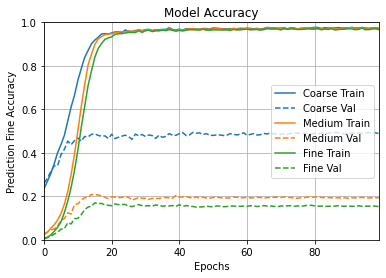

In [18]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

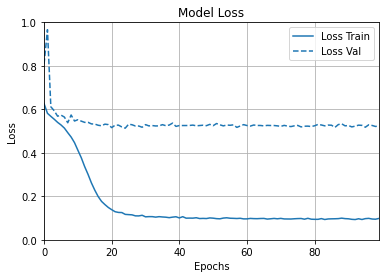

In [19]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [21]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

252/252 [==============================] - 35s 125ms/step - loss: 0.5255 - prediction_coarse_loss: 0.3737 - prediction_medium_loss: 0.6223 - prediction_fine_loss: 0.6802 - prediction_coarse_accuracy: 0.4884 - prediction_medium_accuracy: 0.1937 - prediction_fine_accuracy: 0.1524
1. loss ==> 0.5255011916160583
2. prediction_coarse_loss ==> 0.37370672821998596
3. prediction_medium_loss ==> 0.6223033666610718
4. prediction_fine_loss ==> 0.6802141666412354
5. prediction_coarse_accuracy ==> 0.4884357154369354
6. prediction_medium_accuracy ==> 0.19373290240764618
7. prediction_fine_accuracy ==> 0.15244963765144348


In [22]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    image = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
                image.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
                image[i] = list(x[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
                image[i] = image[i] + list(x[i].numpy())
    return y_true, y_pred, image

In [23]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [24]:
dataset= {'x_test':predictions[0][2][0], 
          'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [25]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[208 106   0   0   3  28   0   6   0 122  16   3   3]
 [ 63 285   0   0   0  39   0   6   2 185  15   5   3]
 [  5   2   1   0   0   0   0   0   0   2   3   0   0]
 [  6   8   0  59  12   3   0   2   7  11  59   2   3]
 [  3   4   0  25  28   1   0   1   6   3  17   5   1]
 [ 27  74   0   5   0  51   0   5   0 105  30   5   4]
 [  4  18   0   0   0   3   1   0   0  23   1   0   0]
 [  6  14   0   0   2   9   0  35   1  43  31   6   3]
 [  3   1   0  19   7   1   0   0  14   7  24   5   0]
 [ 62 156   0   7   4  56   0  15   0 666  73   3  16]
 [ 17  30   0  21   5  25   0   9   3  82 508   4  10]
 [  6   8   0   3   0   3   0   2   2   7  14  95   1]
 [ 11  16   0   6   0   6   0   4   0  53  33   2  13]]

  • MEDIUM LEVEL 
[[ 4  1  0 ...  1  1  0]
 [ 0 26  0 ...  0  0  1]
 [ 0  0 19 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  3  1]
 [ 0  0  1 ...  0  0  1]]

  • FINE LEVEL 
[[8 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 2 3 ... 0

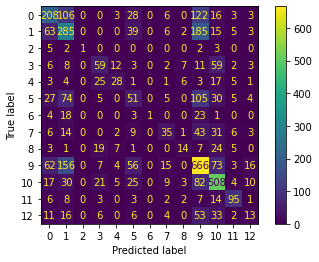

              precision    recall  f1-score   support

           0    0.49406   0.42020   0.45415       495
           1    0.39474   0.47264   0.43019       603
           2    1.00000   0.07692   0.14286        13
           3    0.40690   0.34302   0.37224       172
           4    0.45902   0.29787   0.36129        94
           5    0.22667   0.16667   0.19209       306
           6    1.00000   0.02000   0.03922        50
           7    0.41176   0.23333   0.29787       150
           8    0.40000   0.17284   0.24138        81
           9    0.50879   0.62949   0.56274      1058
          10    0.61650   0.71148   0.66060       714
          11    0.70370   0.67376   0.68841       141
          12    0.22807   0.09028   0.12935       144

    accuracy                        0.48844      4021
   macro avg    0.52694   0.33142   0.35172      4021
weighted avg    0.48067   0.48844   0.47047      4021


  • MEDIUM LEVEL 


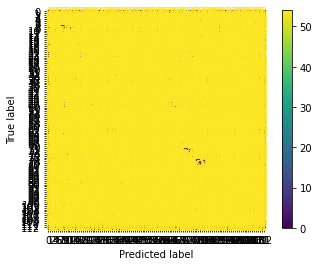

              precision    recall  f1-score   support

           0    0.11111   0.10811   0.10959        37
           1    0.20472   0.30233   0.24413        86
           2    0.37255   0.50000   0.42697        38
           3    0.37500   0.31579   0.34286        19
           4    0.18182   0.09524   0.12500        42
           5    0.23529   0.29268   0.26087        41
           6    0.23684   0.19565   0.21429        46
           7    0.15385   0.18367   0.16744        98
           8    0.15789   0.13043   0.14286        23
           9    0.21642   0.27358   0.24167       106
          10    0.09091   0.05263   0.06667        19
          11    0.16667   0.07692   0.10526        13
          12    0.14634   0.15000   0.14815        40
          13    0.22951   0.23333   0.23140        60
          14    0.14925   0.12658   0.13699        79
          15    0.17073   0.14894   0.15909        47
          16    0.05660   0.05556   0.05607        54
          17    0.29851   0

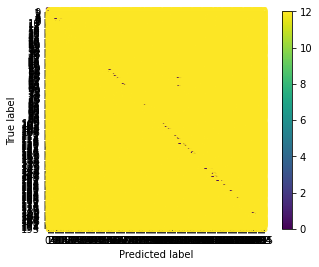

              precision    recall  f1-score   support

           0    0.30769   0.42105   0.35556        19
           1    0.03571   0.05000   0.04167        20
           2    0.10714   0.14286   0.12245        21
           3    0.00000   0.00000   0.00000        24
           4    0.04000   0.04762   0.04348        21
           5    0.12000   0.16667   0.13953        18
           6    0.07407   0.10526   0.08696        19
           7    0.15385   0.09091   0.11429        22
           8    0.05263   0.05556   0.05405        18
           9    0.00000   0.00000   0.00000        20
          10    0.31250   0.43478   0.36364        23
          11    0.21429   0.14286   0.17143        21
          12    0.04762   0.04545   0.04651        22
          13    0.00000   0.00000   0.00000        19
          14    0.33333   0.19048   0.24242        21
          15    0.14815   0.18182   0.16327        22
          16    0.16667   0.05000   0.07692        20
          17    0.15385   0

In [26]:
metrics.lvl_wise_metric(true_label,pred_label)

In [27]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.2645569095581531 
Hierarchical Recall = 0.34593384730166626 
Hierarchical F1-Score = 0.29527520201481905 
Consistency =  0.2581447401143994 
Exact Match =  0.0850534692862472
